In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
IMAGE_SIZE = [224, 224]


In [3]:
train_directory='../input/100-bird-species/train'
test_directory='../input/100-bird-species/test'
val_directory='../input/100-bird-species/valid'

In [4]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
  # useful for getting number of classes
folders = glob('../input/100-bird-species/train/*')
len(folders)

525

In [6]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [7]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_directory,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode =  'categorical')

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [10]:
print(len(training_set)) # number of batches
print(len(test_set))

2645
83


In [11]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/tmp/ipykernel_28/177326590.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
2645/2645 [==============================] - 1520s 570ms/step - loss: 6.5307 - accuracy: 0.3150 - val_loss: 3.7427 - val_accuracy: 0.5798
Epoch 2/10
2645/2645 [==============================] - 1146s 433ms/step - loss: 4.2337 - accuracy: 0.5476 - val_loss: 3.5697 - val_accuracy: 0.6240
Epoch 3/10
2645/2645 [==============================] - 1144s 432ms/step - loss: 3.4967 - accuracy: 0.6306 - val_loss: 3.5742 - val_accuracy: 0.6712
Epoch 4/10
2645/2645 [==============================] - 1157s 437ms/step - loss: 3.0056 - accuracy: 0.6857 - val_loss: 3.4688 - val_accuracy: 0.6907
Epoch 5/10
2645/2645 [==============================] - 1161s 439ms/step - loss: 2.6309 - accuracy: 0.7264 - val_loss: 3.5491 - val_accuracy: 0.7029
Epoch 6/10
2645/2645 [==============================] - 1173s 443ms/step - loss: 2.3777 - accuracy: 0.7529 - val_loss: 3.7094 - val_accuracy: 0.7067
Epoch 7/10
2645/2645 [==============================] - 1149s 434ms/step - loss: 2.1397 - accuracy: 0.7783

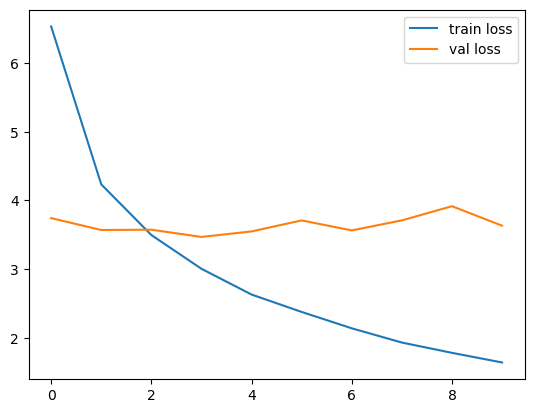

In [12]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

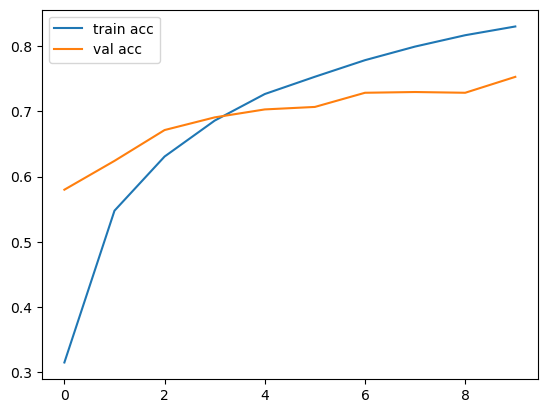

In [13]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [29]:
model.save('BCD.hdf5')


In [16]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img,img_to_array

model1 = load_model('/kaggle/working/BC.h5',compile=False)  

In [18]:
lab = training_set.class_indices
lab={k:v for v,k in lab.items()}

In [19]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model1.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    return res

1/1 [==============================] - 0s 21ms/step


'AMERICAN GOLDFINCH'

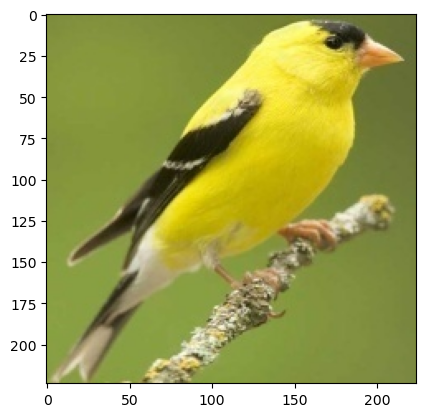

In [22]:
img='/kaggle/input/100-bird-species/valid/AMERICAN GOLDFINCH/4.jpg'
pic=load_img('/kaggle/input/100-bird-species/valid/AMERICAN GOLDFINCH/4.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

In [26]:
import streamlit as st
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.models import load_model

model = load_model('/kaggle/working/BC.h5',compile=False)


lab = {0: 'ABBOTTS BABBLER',
 1: 'ABBOTTS BOOBY',
 2: 'ABYSSINIAN GROUND HORNBILL',
 3: 'AFRICAN CROWNED CRANE',
 4: 'AFRICAN EMERALD CUCKOO',
 5: 'AFRICAN FIREFINCH',
 6: 'AFRICAN OYSTER CATCHER',
 7: 'AFRICAN PIED HORNBILL',
 8: 'AFRICAN PYGMY GOOSE',
 9: 'ALBATROSS',
 10: 'ALBERTS TOWHEE',
 11: 'ALEXANDRINE PARAKEET',
 12: 'ALPINE CHOUGH',
 13: 'ALTAMIRA YELLOWTHROAT',
 14: 'AMERICAN AVOCET',
 15: 'AMERICAN BITTERN',
 16: 'AMERICAN COOT',
 17: 'AMERICAN DIPPER',
 18: 'AMERICAN FLAMINGO',
 19: 'AMERICAN GOLDFINCH',
 20: 'AMERICAN KESTREL',
 21: 'AMERICAN PIPIT',
 22: 'AMERICAN REDSTART',
 23: 'AMERICAN ROBIN',
 24: 'AMERICAN WIGEON',
 25: 'AMETHYST WOODSTAR',
 26: 'ANDEAN GOOSE',
 27: 'ANDEAN LAPWING',
 28: 'ANDEAN SISKIN',
 29: 'ANHINGA',
 30: 'ANIANIAU',
 31: 'ANNAS HUMMINGBIRD',
 32: 'ANTBIRD',
 33: 'ANTILLEAN EUPHONIA',
 34: 'APAPANE',
 35: 'APOSTLEBIRD',
 36: 'ARARIPE MANAKIN',
 37: 'ASHY STORM PETREL',
 38: 'ASHY THRUSHBIRD',
 39: 'ASIAN CRESTED IBIS',
 40: 'ASIAN DOLLARD BIRD',
 41: 'ASIAN GREEN BEE EATER',
 42: 'ASIAN OPENBILL STORK',
 43: 'AUCKLAND SHAQ',
 44: 'AUSTRAL CANASTERO',
 45: 'AUSTRALASIAN FIGBIRD',
 46: 'AVADAVAT',
 47: 'AZARAS SPINETAIL',
 48: 'AZURE BREASTED PITTA',
 49: 'AZURE JAY',
 50: 'AZURE TANAGER',
 51: 'AZURE TIT',
 52: 'BAIKAL TEAL',
 53: 'BALD EAGLE',
 54: 'BALD IBIS',
 55: 'BALI STARLING',
 56: 'BALTIMORE ORIOLE',
 57: 'BANANAQUIT',
 58: 'BAND TAILED GUAN',
 59: 'BANDED BROADBILL',
 60: 'BANDED PITA',
 61: 'BANDED STILT',
 62: 'BAR-TAILED GODWIT',
 63: 'BARN OWL',
 64: 'BARN SWALLOW',
 65: 'BARRED PUFFBIRD',
 66: 'BARROWS GOLDENEYE',
 67: 'BAY-BREASTED WARBLER',
 68: 'BEARDED BARBET',
 69: 'BEARDED BELLBIRD',
 70: 'BEARDED REEDLING',
 71: 'BELTED KINGFISHER',
 72: 'BIRD OF PARADISE',
 73: 'BLACK AND YELLOW BROADBILL',
 74: 'BLACK BAZA',
 75: 'BLACK BREASTED PUFFBIRD',
 76: 'BLACK COCKATO',
 77: 'BLACK FACED SPOONBILL',
 78: 'BLACK FRANCOLIN',
 79: 'BLACK HEADED CAIQUE',
 80: 'BLACK NECKED STILT',
 81: 'BLACK SKIMMER',
 82: 'BLACK SWAN',
 83: 'BLACK TAIL CRAKE',
 84: 'BLACK THROATED BUSHTIT',
 85: 'BLACK THROATED HUET',
 86: 'BLACK THROATED WARBLER',
 87: 'BLACK VENTED SHEARWATER',
 88: 'BLACK VULTURE',
 89: 'BLACK-CAPPED CHICKADEE',
 90: 'BLACK-NECKED GREBE',
 91: 'BLACK-THROATED SPARROW',
 92: 'BLACKBURNIAM WARBLER',
 93: 'BLONDE CRESTED WOODPECKER',
 94: 'BLOOD PHEASANT',
 95: 'BLUE COAU',
 96: 'BLUE DACNIS',
 97: 'BLUE GRAY GNATCATCHER',
 98: 'BLUE GROSBEAK',
 99: 'BLUE GROUSE',
 100: 'BLUE HERON',
 101: 'BLUE MALKOHA',
 102: 'BLUE THROATED PIPING GUAN',
 103: 'BLUE THROATED TOUCANET',
 104: 'BOBOLINK',
 105: 'BORNEAN BRISTLEHEAD',
 106: 'BORNEAN LEAFBIRD',
 107: 'BORNEAN PHEASANT',
 108: 'BRANDT CORMARANT',
 109: 'BREWERS BLACKBIRD',
 110: 'BROWN CREPPER',
 111: 'BROWN HEADED COWBIRD',
 112: 'BROWN NOODY',
 113: 'BROWN THRASHER',
 114: 'BUFFLEHEAD',
 115: 'BULWERS PHEASANT',
 116: 'BURCHELLS COURSER',
 117: 'BUSH TURKEY',
 118: 'CAATINGA CACHOLOTE',
 119: 'CABOTS TRAGOPAN',
 120: 'CACTUS WREN',
 121: 'CALIFORNIA CONDOR',
 122: 'CALIFORNIA GULL',
 123: 'CALIFORNIA QUAIL',
 124: 'CAMPO FLICKER',
 125: 'CANARY',
 126: 'CANVASBACK',
 127: 'CAPE GLOSSY STARLING',
 128: 'CAPE LONGCLAW',
 129: 'CAPE MAY WARBLER',
 130: 'CAPE ROCK THRUSH',
 131: 'CAPPED HERON',
 132: 'CAPUCHINBIRD',
 133: 'CARMINE BEE-EATER',
 134: 'CASPIAN TERN',
 135: 'CASSOWARY',
 136: 'CEDAR WAXWING',
 137: 'CERULEAN WARBLER',
 138: 'CHARA DE COLLAR',
 139: 'CHATTERING LORY',
 140: 'CHESTNET BELLIED EUPHONIA',
 141: 'CHESTNUT WINGED CUCKOO',
 142: 'CHINESE BAMBOO PARTRIDGE',
 143: 'CHINESE POND HERON',
 144: 'CHIPPING SPARROW',
 145: 'CHUCAO TAPACULO',
 146: 'CHUKAR PARTRIDGE',
 147: 'CINNAMON ATTILA',
 148: 'CINNAMON FLYCATCHER',
 149: 'CINNAMON TEAL',
 150: 'CLARKS GREBE',
 151: 'CLARKS NUTCRACKER',
 152: 'COCK OF THE  ROCK',
 153: 'COCKATOO',
 154: 'COLLARED ARACARI',
 155: 'COLLARED CRESCENTCHEST',
 156: 'COMMON FIRECREST',
 157: 'COMMON GRACKLE',
 158: 'COMMON HOUSE MARTIN',
 159: 'COMMON IORA',
 160: 'COMMON LOON',
 161: 'COMMON POORWILL',
 162: 'COMMON STARLING',
 163: 'COPPERSMITH BARBET',
 164: 'COPPERY TAILED COUCAL',
 165: 'CRAB PLOVER',
 166: 'CRANE HAWK',
 167: 'CREAM COLORED WOODPECKER',
 168: 'CRESTED AUKLET',
 169: 'CRESTED CARACARA',
 170: 'CRESTED COUA',
 171: 'CRESTED FIREBACK',
 172: 'CRESTED KINGFISHER',
 173: 'CRESTED NUTHATCH',
 174: 'CRESTED OROPENDOLA',
 175: 'CRESTED SERPENT EAGLE',
 176: 'CRESTED SHRIKETIT',
 177: 'CRESTED WOOD PARTRIDGE',
 178: 'CRIMSON CHAT',
 179: 'CRIMSON SUNBIRD',
 180: 'CROW',
 181: 'CUBAN TODY',
 182: 'CUBAN TROGON',
 183: 'CURL CRESTED ARACURI',
 184: 'D-ARNAUDS BARBET',
 185: 'DALMATIAN PELICAN',
 186: 'DARJEELING WOODPECKER',
 187: 'DARK EYED JUNCO',
 188: 'DAURIAN REDSTART',
 189: 'DEMOISELLE CRANE',
 190: 'DOUBLE BARRED FINCH',
 191: 'DOUBLE BRESTED CORMARANT',
 192: 'DOUBLE EYED FIG PARROT',
 193: 'DOWNY WOODPECKER',
 194: 'DUNLIN',
 195: 'DUSKY LORY',
 196: 'DUSKY ROBIN',
 197: 'EARED PITA',
 198: 'EASTERN BLUEBIRD',
 199: 'EASTERN BLUEBONNET',
 200: 'EASTERN GOLDEN WEAVER',
 201: 'EASTERN MEADOWLARK',
 202: 'EASTERN ROSELLA',
 203: 'EASTERN TOWEE',
 204: 'EASTERN WIP POOR WILL',
 205: 'EASTERN YELLOW ROBIN',
 206: 'ECUADORIAN HILLSTAR',
 207: 'EGYPTIAN GOOSE',
 208: 'ELEGANT TROGON',
 209: 'ELLIOTS  PHEASANT',
 210: 'EMERALD TANAGER',
 211: 'EMPEROR PENGUIN',
 212: 'EMU',
 213: 'ENGGANO MYNA',
 214: 'EURASIAN BULLFINCH',
 215: 'EURASIAN GOLDEN ORIOLE',
 216: 'EURASIAN MAGPIE',
 217: 'EUROPEAN GOLDFINCH',
 218: 'EUROPEAN TURTLE DOVE',
 219: 'EVENING GROSBEAK',
 220: 'FAIRY BLUEBIRD',
 221: 'FAIRY PENGUIN',
 222: 'FAIRY TERN',
 223: 'FAN TAILED WIDOW',
 224: 'FASCIATED WREN',
 225: 'FIERY MINIVET',
 226: 'FIORDLAND PENGUIN',
 227: 'FIRE TAILLED MYZORNIS',
 228: 'FLAME BOWERBIRD',
 229: 'FLAME TANAGER',
 230: 'FOREST WAGTAIL',
 231: 'FRIGATE',
 232: 'FRILL BACK PIGEON',
 233: 'GAMBELS QUAIL',
 234: 'GANG GANG COCKATOO',
 235: 'GILA WOODPECKER',
 236: 'GILDED FLICKER',
 237: 'GLOSSY IBIS',
 238: 'GO AWAY BIRD',
 239: 'GOLD WING WARBLER',
 240: 'GOLDEN BOWER BIRD',
 241: 'GOLDEN CHEEKED WARBLER',
 242: 'GOLDEN CHLOROPHONIA',
 243: 'GOLDEN EAGLE',
 244: 'GOLDEN PARAKEET',
 245: 'GOLDEN PHEASANT',
 246: 'GOLDEN PIPIT',
 247: 'GOULDIAN FINCH',
 248: 'GRANDALA',
 249: 'GRAY CATBIRD',
 250: 'GRAY KINGBIRD',
 251: 'GRAY PARTRIDGE',
 252: 'GREAT ARGUS',
 253: 'GREAT GRAY OWL',
 254: 'GREAT JACAMAR',
 255: 'GREAT KISKADEE',
 256: 'GREAT POTOO',
 257: 'GREAT TINAMOU',
 258: 'GREAT XENOPS',
 259: 'GREATER PEWEE',
 260: 'GREATER PRAIRIE CHICKEN',
 261: 'GREATOR SAGE GROUSE',
 262: 'GREEN BROADBILL',
 263: 'GREEN JAY',
 264: 'GREEN MAGPIE',
 265: 'GREEN WINGED DOVE',
 266: 'GREY CUCKOOSHRIKE',
 267: 'GREY HEADED CHACHALACA',
 268: 'GREY HEADED FISH EAGLE',
 269: 'GREY PLOVER',
 270: 'GROVED BILLED ANI',
 271: 'GUINEA TURACO',
 272: 'GUINEAFOWL',
 273: 'GURNEYS PITTA',
 274: 'GYRFALCON',
 275: 'HAMERKOP',
 276: 'HARLEQUIN DUCK',
 277: 'HARLEQUIN QUAIL',
 278: 'HARPY EAGLE',
 279: 'HAWAIIAN GOOSE',
 280: 'HAWFINCH',
 281: 'HELMET VANGA',
 282: 'HEPATIC TANAGER',
 283: 'HIMALAYAN BLUETAIL',
 284: 'HIMALAYAN MONAL',
 285: 'HOATZIN',
 286: 'HOODED MERGANSER',
 287: 'HOOPOES',
 288: 'HORNED GUAN',
 289: 'HORNED LARK',
 290: 'HORNED SUNGEM',
 291: 'HOUSE FINCH',
 292: 'HOUSE SPARROW',
 293: 'HYACINTH MACAW',
 294: 'IBERIAN MAGPIE',
 295: 'IBISBILL',
 296: 'IMPERIAL SHAQ',
 297: 'INCA TERN',
 298: 'INDIAN BUSTARD',
 299: 'INDIAN PITTA',
 300: 'INDIAN ROLLER',
 301: 'INDIAN VULTURE',
 302: 'INDIGO BUNTING',
 303: 'INDIGO FLYCATCHER',
 304: 'INLAND DOTTEREL',
 305: 'IVORY BILLED ARACARI',
 306: 'IVORY GULL',
 307: 'IWI',
 308: 'JABIRU',
 309: 'JACK SNIPE',
 310: 'JACOBIN PIGEON',
 311: 'JANDAYA PARAKEET',
 312: 'JAPANESE ROBIN',
 313: 'JAVA SPARROW',
 314: 'JOCOTOCO ANTPITTA',
 315: 'KAGU',
 316: 'KAKAPO',
 317: 'KILLDEAR',
 318: 'KING EIDER',
 319: 'KING VULTURE',
 320: 'KIWI',
 321: 'KNOB BILLED DUCK',
 322: 'KOOKABURRA',
 323: 'LARK BUNTING',
 324: 'LAUGHING GULL',
 325: 'LAZULI BUNTING',
 326: 'LESSER ADJUTANT',
 327: 'LILAC ROLLER',
 328: 'LIMPKIN',
 329: 'LITTLE AUK',
 330: 'LOGGERHEAD SHRIKE',
 331: 'LONG-EARED OWL',
 332: 'LOONEY BIRDS',
 333: 'LUCIFER HUMMINGBIRD',
 334: 'MAGPIE GOOSE',
 335: 'MALABAR HORNBILL',
 336: 'MALACHITE KINGFISHER',
 337: 'MALAGASY WHITE EYE',
 338: 'MALEO',
 339: 'MALLARD DUCK',
 340: 'MANDRIN DUCK',
 341: 'MANGROVE CUCKOO',
 342: 'MARABOU STORK',
 343: 'MASKED BOBWHITE',
 344: 'MASKED BOOBY',
 345: 'MASKED LAPWING',
 346: 'MCKAYS BUNTING',
 347: 'MERLIN',
 348: 'MIKADO  PHEASANT',
 349: 'MILITARY MACAW',
 350: 'MOURNING DOVE',
 351: 'MYNA',
 352: 'NICOBAR PIGEON',
 353: 'NOISY FRIARBIRD',
 354: 'NORTHERN BEARDLESS TYRANNULET',
 355: 'NORTHERN CARDINAL',
 356: 'NORTHERN FLICKER',
 357: 'NORTHERN FULMAR',
 358: 'NORTHERN GANNET',
 359: 'NORTHERN GOSHAWK',
 360: 'NORTHERN JACANA',
 361: 'NORTHERN MOCKINGBIRD',
 362: 'NORTHERN PARULA',
 363: 'NORTHERN RED BISHOP',
 364: 'NORTHERN SHOVELER',
 365: 'OCELLATED TURKEY',
 366: 'OILBIRD',
 367: 'OKINAWA RAIL',
 368: 'ORANGE BREASTED TROGON',
 369: 'ORANGE BRESTED BUNTING',
 370: 'ORIENTAL BAY OWL',
 371: 'ORNATE HAWK EAGLE',
 372: 'OSPREY',
 373: 'OSTRICH',
 374: 'OVENBIRD',
 375: 'OYSTER CATCHER',
 376: 'PAINTED BUNTING',
 377: 'PALILA',
 378: 'PALM NUT VULTURE',
 379: 'PARADISE TANAGER',
 380: 'PARAKETT  AUKLET',
 381: 'PARUS MAJOR',
 382: 'PATAGONIAN SIERRA FINCH',
 383: 'PEACOCK',
 384: 'PEREGRINE FALCON',
 385: 'PHAINOPEPLA',
 386: 'PHILIPPINE EAGLE',
 387: 'PINK ROBIN',
 388: 'PLUSH CRESTED JAY',
 389: 'POMARINE JAEGER',
 390: 'PUFFIN',
 391: 'PUNA TEAL',
 392: 'PURPLE FINCH',
 393: 'PURPLE GALLINULE',
 394: 'PURPLE MARTIN',
 395: 'PURPLE SWAMPHEN',
 396: 'PYGMY KINGFISHER',
 397: 'PYRRHULOXIA',
 398: 'QUETZAL',
 399: 'RAINBOW LORIKEET',
 400: 'RAZORBILL',
 401: 'RED BEARDED BEE EATER',
 402: 'RED BELLIED PITTA',
 403: 'RED BILLED TROPICBIRD',
 404: 'RED BROWED FINCH',
 405: 'RED CROSSBILL',
 406: 'RED FACED CORMORANT',
 407: 'RED FACED WARBLER',
 408: 'RED FODY',
 409: 'RED HEADED DUCK',
 410: 'RED HEADED WOODPECKER',
 411: 'RED KNOT',
 412: 'RED LEGGED HONEYCREEPER',
 413: 'RED NAPED TROGON',
 414: 'RED SHOULDERED HAWK',
 415: 'RED TAILED HAWK',
 416: 'RED TAILED THRUSH',
 417: 'RED WINGED BLACKBIRD',
 418: 'RED WISKERED BULBUL',
 419: 'REGENT BOWERBIRD',
 420: 'RING-NECKED PHEASANT',
 421: 'ROADRUNNER',
 422: 'ROCK DOVE',
 423: 'ROSE BREASTED COCKATOO',
 424: 'ROSE BREASTED GROSBEAK',
 425: 'ROSEATE SPOONBILL',
 426: 'ROSY FACED LOVEBIRD',
 427: 'ROUGH LEG BUZZARD',
 428: 'ROYAL FLYCATCHER',
 429: 'RUBY CROWNED KINGLET',
 430: 'RUBY THROATED HUMMINGBIRD',
 431: 'RUDDY SHELDUCK',
 432: 'RUDY KINGFISHER',
 433: 'RUFOUS KINGFISHER',
 434: 'RUFOUS TREPE',
 435: 'RUFUOS MOTMOT',
 436: 'SAMATRAN THRUSH',
 437: 'SAND MARTIN',
 438: 'SANDHILL CRANE',
 439: 'SATYR TRAGOPAN',
 440: 'SAYS PHOEBE',
 441: 'SCARLET CROWNED FRUIT DOVE',
 442: 'SCARLET FACED LIOCICHLA',
 443: 'SCARLET IBIS',
 444: 'SCARLET MACAW',
 445: 'SCARLET TANAGER',
 446: 'SHOEBILL',
 447: 'SHORT BILLED DOWITCHER',
 448: 'SMITHS LONGSPUR',
 449: 'SNOW GOOSE',
 450: 'SNOW PARTRIDGE',
 451: 'SNOWY EGRET',
 452: 'SNOWY OWL',
 453: 'SNOWY PLOVER',
 454: 'SNOWY SHEATHBILL',
 455: 'SORA',
 456: 'SPANGLED COTINGA',
 457: 'SPLENDID WREN',
 458: 'SPOON BILED SANDPIPER',
 459: 'SPOTTED CATBIRD',
 460: 'SPOTTED WHISTLING DUCK',
 461: 'SQUACCO HERON',
 462: 'SRI LANKA BLUE MAGPIE',
 463: 'STEAMER DUCK',
 464: 'STORK BILLED KINGFISHER',
 465: 'STRIATED CARACARA',
 466: 'STRIPED OWL',
 467: 'STRIPPED MANAKIN',
 468: 'STRIPPED SWALLOW',
 469: 'SUNBITTERN',
 470: 'SUPERB STARLING',
 471: 'SURF SCOTER',
 472: 'SWINHOES PHEASANT',
 473: 'TAILORBIRD',
 474: 'TAIWAN MAGPIE',
 475: 'TAKAHE',
 476: 'TASMANIAN HEN',
 477: 'TAWNY FROGMOUTH',
 478: 'TEAL DUCK',
 479: 'TIT MOUSE',
 480: 'TOUCHAN',
 481: 'TOWNSENDS WARBLER',
 482: 'TREE SWALLOW',
 483: 'TRICOLORED BLACKBIRD',
 484: 'TROPICAL KINGBIRD',
 485: 'TRUMPTER SWAN',
 486: 'TURKEY VULTURE',
 487: 'TURQUOISE MOTMOT',
 488: 'UMBRELLA BIRD',
 489: 'VARIED THRUSH',
 490: 'VEERY',
 491: 'VENEZUELIAN TROUPIAL',
 492: 'VERDIN',
 493: 'VERMILION FLYCATHER',
 494: 'VICTORIA CROWNED PIGEON',
 495: 'VIOLET BACKED STARLING',
 496: 'VIOLET CUCKOO',
 497: 'VIOLET GREEN SWALLOW',
 498: 'VIOLET TURACO',
 499: 'VISAYAN HORNBILL',
 500: 'VULTURINE GUINEAFOWL',
 501: 'WALL CREAPER',
 502: 'WATTLED CURASSOW',
 503: 'WATTLED LAPWING',
 504: 'WHIMBREL',
 505: 'WHITE BREASTED WATERHEN',
 506: 'WHITE BROWED CRAKE',
 507: 'WHITE CHEEKED TURACO',
 508: 'WHITE CRESTED HORNBILL',
 509: 'WHITE EARED HUMMINGBIRD',
 510: 'WHITE NECKED RAVEN',
 511: 'WHITE TAILED TROPIC',
 512: 'WHITE THROATED BEE EATER',
 513: 'WILD TURKEY',
 514: 'WILLOW PTARMIGAN',
 515: 'WILSONS BIRD OF PARADISE',
 516: 'WOOD DUCK',
 517: 'WOOD THRUSH',
 518: 'WOODLAND KINGFISHER',
 519: 'WRENTIT',
 520: 'YELLOW BELLIED FLOWERPECKER',
 521: 'YELLOW BREASTED CHAT',
 522: 'YELLOW CACIQUE',
 523: 'YELLOW HEADED BLACKBIRD',
 524: 'ZEBRA DOVE'}



def processed_img(img_path):
    img=load_img(img_path,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    print(y_class)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    print(res)
    return res

def run():
    img1 = Image.open('./meta/logo1.png')
    img1 = img1.resize((350,350))
    st.image(img1,use_column_width=False)
    st.title("Birds Species Classification")
    st.markdown('''<h4 style='text-align: left; color: #d73b5c;'>* Data is based "270 Bird Species also see 70 Sports Dataset"</h4>''',
                unsafe_allow_html=True)

    img_file = st.file_uploader("Choose an Image of Bird", type=["jpg", "png"])
    if img_file is not None:
        st.image(img_file,use_column_width=False)
        save_image_path = './upload_images/'+img_file.name
        with open(save_image_path, "wb") as f:
            f.write(img_file.getbuffer())

        if st.button("Predict"):
            result = processed_img(save_image_path)
            st.success("Predicted Bird is: "+result)
run()

FileNotFoundError: [Errno 2] No such file or directory: './meta/logo1.png'

In [24]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.0 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=1898354c8ed0b5cc9394794a1bec4c94ec56c6708b48b7d8ac475de8f54cca19
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1


In [27]:
!kaggle datasets download -d username/datasetname -f /kaggle/working/BC.h5

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
